# CREAM Pipeline Profiling Analysis

### Prerequisites

None. Exemplary logs are loaded by default. Experiments were run on:

* Storage: CEPH HDDs
* CPU: Intel Xeon E5-2630 v3 8x@2.4GHz
* Image: ubuntu-18.04-lts/Openstack
* Memory: 80GB DDR4

All plots that are not saved with the `save_fig` function were not used in the paper, but may provide a close-up look on specific values.

### Meta information

* Dataset size: `39.565648284999995` GB (`X8/du -bh .` / 1000 / 1000 / 1000)
* Amount of `.hdf5` files (total hours): `744` (`find . -name "*.hdf5' | wc -l`)
* Amount of days: `47` (`ls -la | grep 2018 | wc -l`)
* Avg. filesize: `53.17963479166666` MB (dataset size / filecount)
* 1h in each file, each sample is 10s: `0.1477212077546296` MB (avg. filesize / 60 / 6)
* Sample sizes (rounded to second decimal):
    * `0500:      73.86 MB` 
    * `1000:     147.72 MB`
    * `2000:     295.44 MB`
    * `4000:     590.88 MB`
    * `8000:    1181.77 MB`
    * `267840: 39565.65 MB`

In [1]:
cream_mains_frequency_hz = 50
cream_sps = 6400
cream_period_length = cream_sps / cream_mains_frequency_hz
print(f"Cream period: {int(cream_period_length)}")
total_hours = 744
window_size_s = 10 # taken from MEED
print(f"Window Size: {window_size_s}s")
windows_per_hour = (60 * 60) / window_size_s
# float64 = 8 byte, voltage + current = "*2"
raw_data_size_per_hour_mb = windows_per_hour * window_size_s * cream_sps * 8 * 2 / 1000 / 1000
print(f"Data per hour: {raw_data_size_per_hour_mb}MB")
samples_per_hour = cream_sps * 60 * 60
print(f"Samples per hour: {samples_per_hour}")
samples_per_window_size = cream_sps * window_size_s
print(f"Samples per windowsize: {samples_per_window_size}")
full_dataset_windowcount = total_hours * windows_per_hour
print(f"Windows Total: {int(full_dataset_windowcount)}")

for sample_size in [500, 1000, 2000, 4000, 8000]:
    print(f"{sample_size} of total: {round(sample_size / full_dataset_windowcount * 100, 2)}%")
    
full_dataset_samplecount = int(full_dataset_windowcount)

Cream period: 128
Window Size: 10s
Data per hour: 368.64MB
Samples per hour: 23040000
Samples per windowsize: 64000
Windows Total: 267840
500 of total: 0.19%
1000 of total: 0.37%
2000 of total: 0.75%
4000 of total: 1.49%
8000 of total: 2.99%


In [2]:
%load_ext autoreload
%autoreload 2
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from matplotlib import ticker
from typing import List
# adding previous directory for easier use of library
import sys
sys.path.append('../')
from notebookhelper import show_values_on_bars, show_values_on_catplot, save_figure, make_big_number_prettier \
                         , make_big_number_prettier_storage_mb

from presto.analysis import StrategyAnalysis \
                       , strat_analysis_from_csv

pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
epoch_palette = sns.color_palette("YlOrRd", 3)
samples_palette = sns.color_palette("icefire", 15)
threads_palette = sns.color_palette("tab20", 4)
font_scale = 1.4
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

In [3]:
local_fig_dir = "cream-pipeline"

def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir=local_fig_dir, file_type=file_type)

home_path = "../logs/final-logs/cream/main-experiments"
path_to_cum_df = f"{home_path}/cream-cached-storage-ceph-hdd_2021-10-06-15:27:13_cum-df_samples-500-1000-2000-4000-8000-267840_threads-1-2-4-8.csv"
path_to_cum_dstat_df = f"{home_path}/cream-cached-storage-ceph-hdd_2021-10-06-15:27:13_cum-dstat-df_samples-500-1000-2000-4000-8000-267840_threads-1-2-4-8.csv"

#home_path = "../logs/type-prefetching-logs"
#path_to_cum_df = f"{home_path}/temp-a.csv"
#path_to_cum_dstat_df = f"{home_path}/temp-b.csv"

sampling_tag = ""

analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                   , path_to_cum_df = path_to_cum_df)
cum_dstat_df = analysis.to_cum_dstat_df()
cum_df       = analysis.to_cum_df()
# we forgot to remove the "list-files" step from the profiling, so we do it in this log processing
cum_df = cum_df.query("split_name!='1-list-files'")
cum_dstat_df = cum_dstat_df.query("split_name!='1-list-files'")
# need to sort the strategies for some reason as they are not ascending
cum_df = cum_df.sort_values(by='split_name')
strategies   = list(cum_df.split_name.unique())
strategies_renamed = ["unprocessed", "decoded", "aggregated"]
print(strategies)

['0-fully-online', '2-voltage-+-current-extraction-6.4khz', '3-active-power-+-rms-current-+-cumsum-rms-current']


In [4]:
cum_df.head(5)

,offline_processing_and_save_time_s,shard_count,thread_count,shard_cum_size_MB,sample_count,online_processing_time_s,throughput_sps,runs_count,runs_total,ueid,split_name,creation_timestamp,compression_type,storage_type
0,0.0,1,1,0.0,500,22.990108,21.748484,0,3,dded05,0-fully-online,2021-10-06-15:27:13,none,ceph-hdd
386,0.0,4,4,0.0,2000,74.508255,26.842665,2,3,2e73d8,0-fully-online,2021-10-07-00:03:33,none,ceph-hdd
385,0.0,4,4,0.0,2000,72.986801,27.402216,1,3,2e73d8,0-fully-online,2021-10-07-00:03:33,none,ceph-hdd
384,0.0,4,4,0.0,2000,73.928200,27.053276,0,3,2e73d8,0-fully-online,2021-10-07-00:03:33,none,ceph-hdd
876,0.0,4,4,0.0,4000,132.050339,30.291479,0,3,86b322,0-fully-online,2021-10-07-11:51:21,none,ceph-hdd


In [5]:
cum_dstat_df.head(5)

,rel_time_s,disk_read_mbs,disk_write_mbs,net_read_mbs,net_write_mbs,run,sample_count,shard_count,thread_count,ueid,...,vm_allocated_mb,vm_free_mb,filesystem_files,filesystem_inodes,filelocks_posix,filelocks_lock,filelocks_read,filelocks_write,compression_type,storage_type
0,0.0,0.025011,0.014585,0.000000,0.000000,1,500,1,1,dded05,...,0.01,0.01,1376.0,13893.0,3.0,2.0,0.0,5.0,none,ceph-hdd
1,1.0,0.000000,0.000000,54.598110,0.155577,1,500,1,1,dded05,...,0.21,0.08,1376.0,13903.0,3.0,3.0,1.0,5.0,none,ceph-hdd
2,2.0,0.000000,0.000000,0.000680,0.005359,1,500,1,1,dded05,...,0.27,0.09,1376.0,13903.0,3.0,3.0,1.0,5.0,none,ceph-hdd
3,3.0,0.000000,0.000000,0.000627,0.000207,1,500,1,1,dded05,...,0.33,0.52,1376.0,13903.0,3.0,3.0,1.0,5.0,none,ceph-hdd
4,4.0,0.000000,0.000000,0.000303,0.000150,1,500,1,1,dded05,...,0.32,0.17,1376.0,13903.0,3.0,3.0,1.0,5.0,none,ceph-hdd


## 0. Experiment Information

### 0.1 Experiment Count
We define an experiment as profiling a materialization strategy (e.g., `0-fully-online`) with a certain sample count (e.g., `500`).

We replicated **every** experiment **5** times, that means we should have `5 * <mat-strategies> * <thread_count>` experiments for each sample size. The only exception is the full dataset preprocessing, which is ran with `thread_count = 8`

Unfortunately the `ueid`s are based on the way the experiments were ran (in the python loop vs. bash loop), so we only count the rows, as each row in the `cum_df` dataframe is a single experiment.

In [6]:
experiment_count_dict = {
    "sample_count": []
  , "sample_experiment_count": []
  , "thread_count": []
  , "thread_experiment_count": []
  , "norm_thread_experiment_count": []
  , "runs_count": []
  , "runs_experiment_count": []
}

def get_experiment_count(df):
    '''Short helper'''
    return len(df.index)

def add_to_dict(sample_count, sample_experiment_count
              , thread_count, thread_experiment_count, norm_thread_experiment_count
              , runs_count, runs_experiment_count):
    '''Short helper'''
    experiment_count_dict["sample_count"] += [sample_count]
    experiment_count_dict["sample_experiment_count"] += [sample_experiment_count]
    experiment_count_dict["thread_count"] += [thread_count]
    experiment_count_dict["thread_experiment_count"] += [thread_experiment_count]
    experiment_count_dict["norm_thread_experiment_count"] += [norm_thread_experiment_count]
    experiment_count_dict["runs_count"] += [runs_count]
    experiment_count_dict["runs_experiment_count"] += [runs_experiment_count]


for sample_count in cum_df["sample_count"].unique():
    sample_experiment_count = get_experiment_count(cum_df.query(f"sample_count=={sample_count}"))
    # for each thread setting
    for thread_count in cum_df.query(f"sample_count=={sample_count}")['thread_count'].unique():
        thread_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count} and thread_count=={thread_count}'))
        norm_thread_experiment_count = thread_experiment_count / len(strategies)        
        # for each run (epoch)
        for runs_count in cum_df.query(f"sample_count=={sample_count} and thread_count=={thread_count}")['runs_count'].unique():
            runs_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count} and thread_count=={thread_count} and runs_count=={runs_count}'))
            add_to_dict(sample_count, sample_experiment_count,
                        thread_count, thread_experiment_count, norm_thread_experiment_count, runs_count, runs_experiment_count)
        
experiment_count_df = pd.DataFrame.from_dict(experiment_count_dict)
experiment_count_df

,sample_count,sample_experiment_count,thread_count,thread_experiment_count,norm_thread_experiment_count,runs_count,runs_experiment_count
0,500,180,1,45,15.0,0,15
1,500,180,1,45,15.0,2,15
2,500,180,1,45,15.0,1,15
3,500,180,4,45,15.0,2,15
4,500,180,4,45,15.0,1,15
5,500,180,4,45,15.0,0,15
6,500,180,8,45,15.0,0,15
7,500,180,8,45,15.0,1,15
8,500,180,8,45,15.0,2,15
9,500,180,2,45,15.0,1,15


# 1. Storage Consumption vs Throughput Tradeoffs
### Full dataset, 8 threads, epoch 0

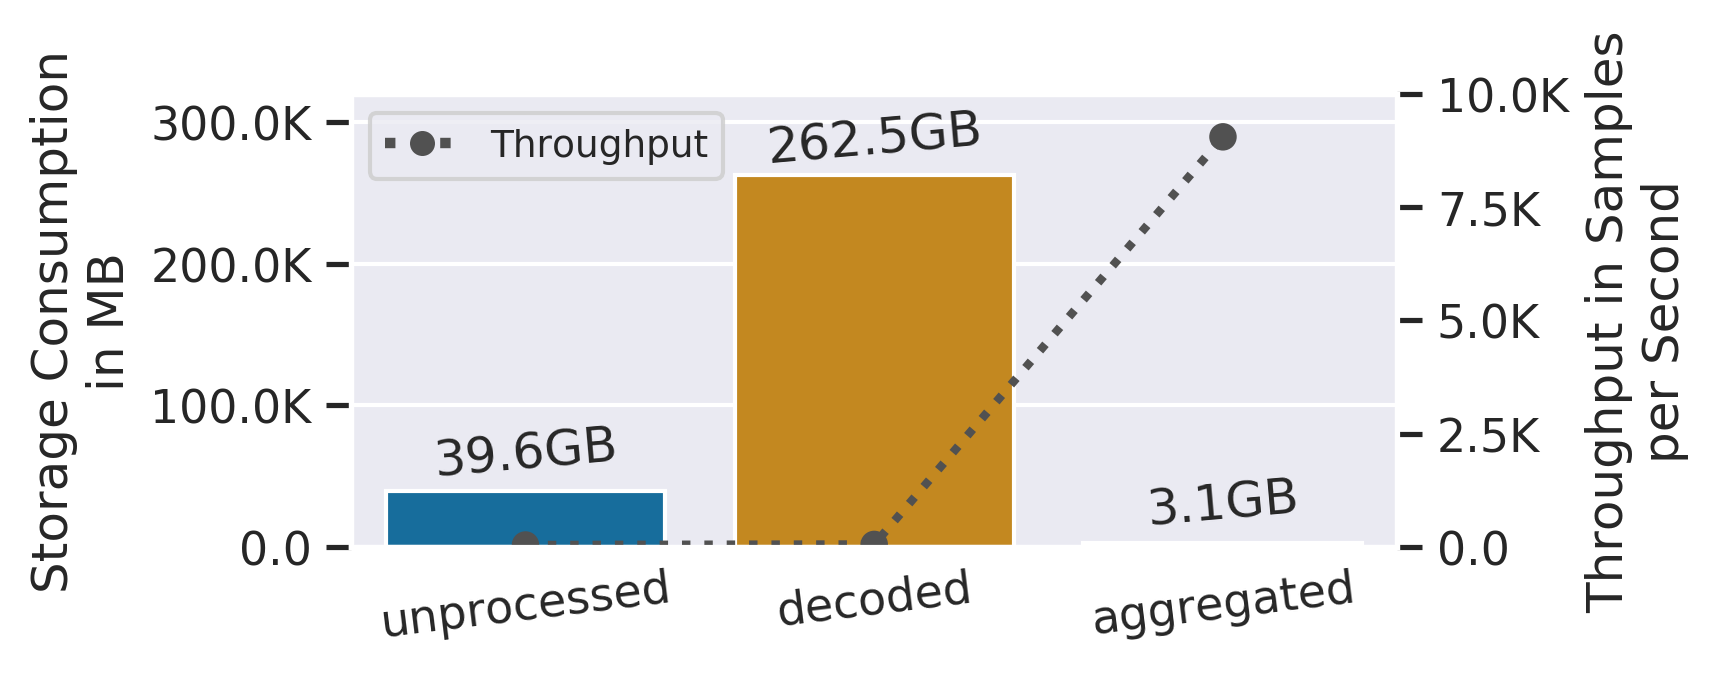

In [15]:
cum_df_temp = cum_df.query(f"sample_count=={full_dataset_samplecount} \
                         and thread_count==8 \
                         and runs_count==0")

sample_size_mb_dict = {
    "500": 74.14
  , "1000": 148.28
  , "2000": 296.57
  , "4000": 593.13
  , "8000": 1186.26
  , f"{full_dataset_samplecount}": 39565.65
}

storage_consumption_comparison = {
    "storage_consumption_mb": []
  , "sample_count": []
  , "strategy": []
}

def add_to_dict(size, sample_count, label):
    '''Short helper'''
    storage_consumption_comparison["storage_consumption_mb"] += [size]
    storage_consumption_comparison["sample_count"] += [sample_count]
    storage_consumption_comparison["strategy"] += [label]
    
for sample_count in cum_df_temp.sample_count.unique():
    for i, strategy in enumerate(strategies):
        shard_sizes_mb = cum_df_temp.query(f"split_name=='{strategy}' and sample_count=={sample_count}")["shard_cum_size_MB"].to_numpy()
        for size_mb in shard_sizes_mb:
            if i == 0: # i.e., unprocessed
                size_mb = sample_size_mb_dict[str(sample_count)]
            add_to_dict(size = size_mb
                      , sample_count = sample_count
                      , label = strategies[i])

storage_df = pd.DataFrame(storage_consumption_comparison)

from matplotlib.lines import Line2D

sns.set(palette=default_palette, font_scale=1.0)
throughput_color = "#515151"
marker = 'o'
linestyle = ":"

fig, ax1 = plt.subplots(figsize=(4.5,2))
ax2 = ax1.twinx()

## throughput plot
plot2 = sns.pointplot(x="split_name", y="throughput_sps", data=cum_df_temp,
                      ax=ax2, scale=0.75, color=throughput_color, linestyles=linestyle, ci=0.95, marker='o')

plot2.set(ylabel="Throughput in Samples\nper Second")
plot2.set_xticklabels(
    strategies_renamed
  , rotation=20
)
ax2.grid(False)
legend_elements = [Line2D([0], [0], marker=marker, markersize=5, color=throughput_color, lw=2.5, label='Throughput', linestyle=linestyle)]
ax2.legend(handles=legend_elements, loc="upper left", prop={'size': 9})
plot2.set(ylim=(0, 10000))          

plot = sns.barplot(
        x="strategy",
        y="storage_consumption_mb",
        data=storage_df.query(f"sample_count=={full_dataset_samplecount}"),
        ax=ax1
    )
plot.set_xticklabels(
    strategies_renamed
  , rotation=7
)
plot.tick_params(axis='x', which='major', pad=-1.5)
show_values_on_bars(plot, h_v="v", space=22000, rotation=5, additional_space=[0,0,0,0,0], storage_formatting=True)
plot.set(ylabel="Storage Consumption\nin MB", xlabel="")
plot.set(ylim=(0, 320000))

plot.yaxis.set_major_formatter(make_big_number_prettier)
plot2.yaxis.set_major_formatter(make_big_number_prettier)
save_fig("storage-vs-throughput")

# 2. Caching Analysis
### Full dataset, 8 threads, epoch 0 + 1 + 2

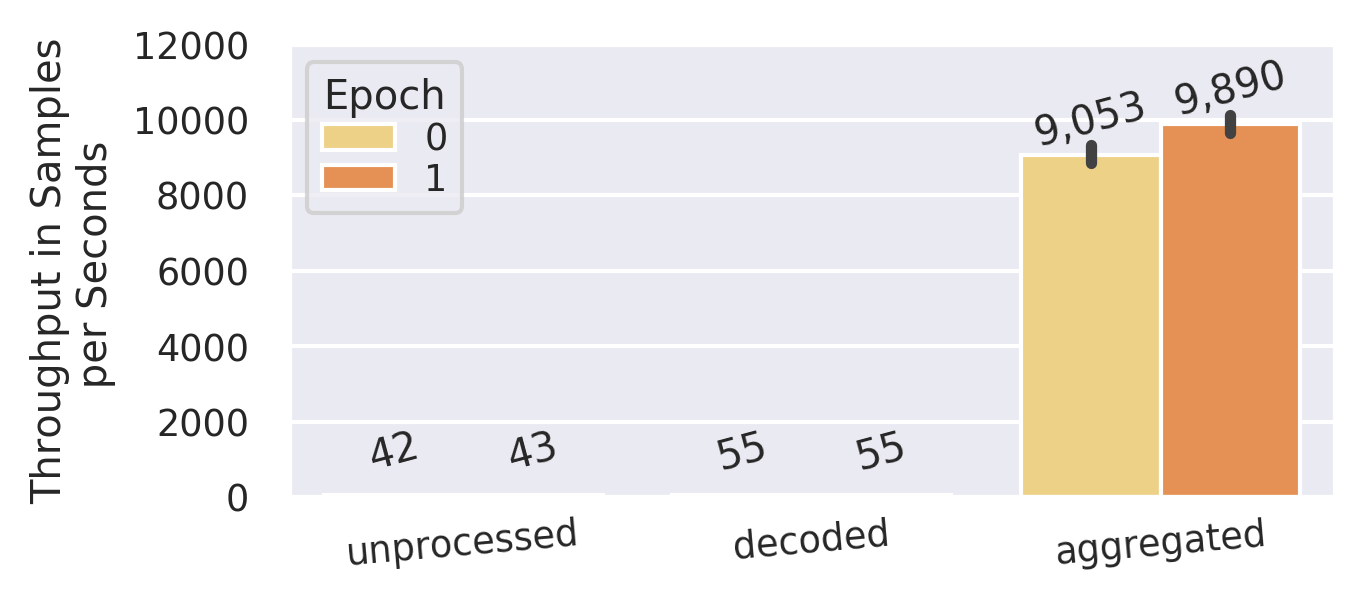

In [20]:
sns.set(palette=epoch_palette, font_scale=0.8)

cum_df_temp = cum_df.query(f"sample_count=={full_dataset_samplecount} \
                         and thread_count==8 and runs_count<=1")

plt.figure(figsize=(4.5,2))
plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="runs_count",
    data=cum_df_temp
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=5
)
plot.tick_params(axis='x', which='major', pad=-1.5)
plot.set(xlabel="", ylabel="Throughput in Samples\n per Seconds")
plot.set(ylim=(0, 12000))
plot.legend(title="Epoch", ncol=1, labelspacing=0.1, loc="upper left")
show_values_on_bars(plot, h_v="v", space=1000, rotation=15)#, additional_space=[0,   0, 250
                                                          #                  ,0,   0, 750
                                                          #                  ,0,   0, 500])
save_fig("caching-over-epochs")

# 3. Compression Analysis (other notebook)

# 4. Number of Samples
## 500, 1000, 2000, 4000, 4890 samples + 8 threads + epoch 0

### Normalizing the processing time per samples and renaming the maximum sample count to "full"

In [21]:
# calculate the per sample processing time for both offline and online processing
cum_df["per_sample_online_processing_time_s"] = cum_df["online_processing_time_s"] / cum_df["sample_count"]
cum_df["per_sample_offline_processing_and_save_time_s"] = cum_df["offline_processing_and_save_time_s"] / cum_df["sample_count"]
# calculate the total processing time for each sample count
cum_df["total_processing_time_s"] = cum_df["online_processing_time_s"] + cum_df["offline_processing_and_save_time_s"]
# extrapolate based on the full count of images
cum_df["full_dataset_online_processing_time_s"] = cum_df["per_sample_online_processing_time_s"] * full_dataset_samplecount
cum_df["full_dataset_offline_processing_and_save_time_s"] = cum_df["per_sample_offline_processing_and_save_time_s"] * full_dataset_samplecount
cum_df["full_dataset_offline_processing_and_save_time_m"] = cum_df["full_dataset_offline_processing_and_save_time_s"] / 60
cum_df["full_dataset_offline_processing_and_save_time_h"] = cum_df["full_dataset_offline_processing_and_save_time_m"] / 60


# sum the offline and online time for the full dataset processing time (converted to hours)
cum_df["full_dataset_processing_time_s"] = cum_df["full_dataset_online_processing_time_s"] + cum_df["full_dataset_offline_processing_and_save_time_s"]
cum_df["full_dataset_processing_time_m"] = cum_df["full_dataset_processing_time_s"] / 60
cum_df["full_dataset_processing_time_h"] = cum_df["full_dataset_processing_time_m"] / 60 


cum_df_mod = cum_df.copy(deep=True)
cum_df_mod.loc[cum_df_mod.sample_count == 267840, 'sample_count'] = '268K (full)'
order_dict = { 500: 10, 1000: 11, 2000: 12, 4000: 13, 8000: 14, '268K (full)': 15}
strategy_order_dict = dict(list(enumerate(strategies)))
strategy_order_dict = dict({(y, x) for x, y in strategy_order_dict.items()})
order_dict.update(strategy_order_dict)
cum_df_mod = cum_df_mod.sort_values(by=['split_name', 'sample_count'], key=lambda x: x.map(order_dict))

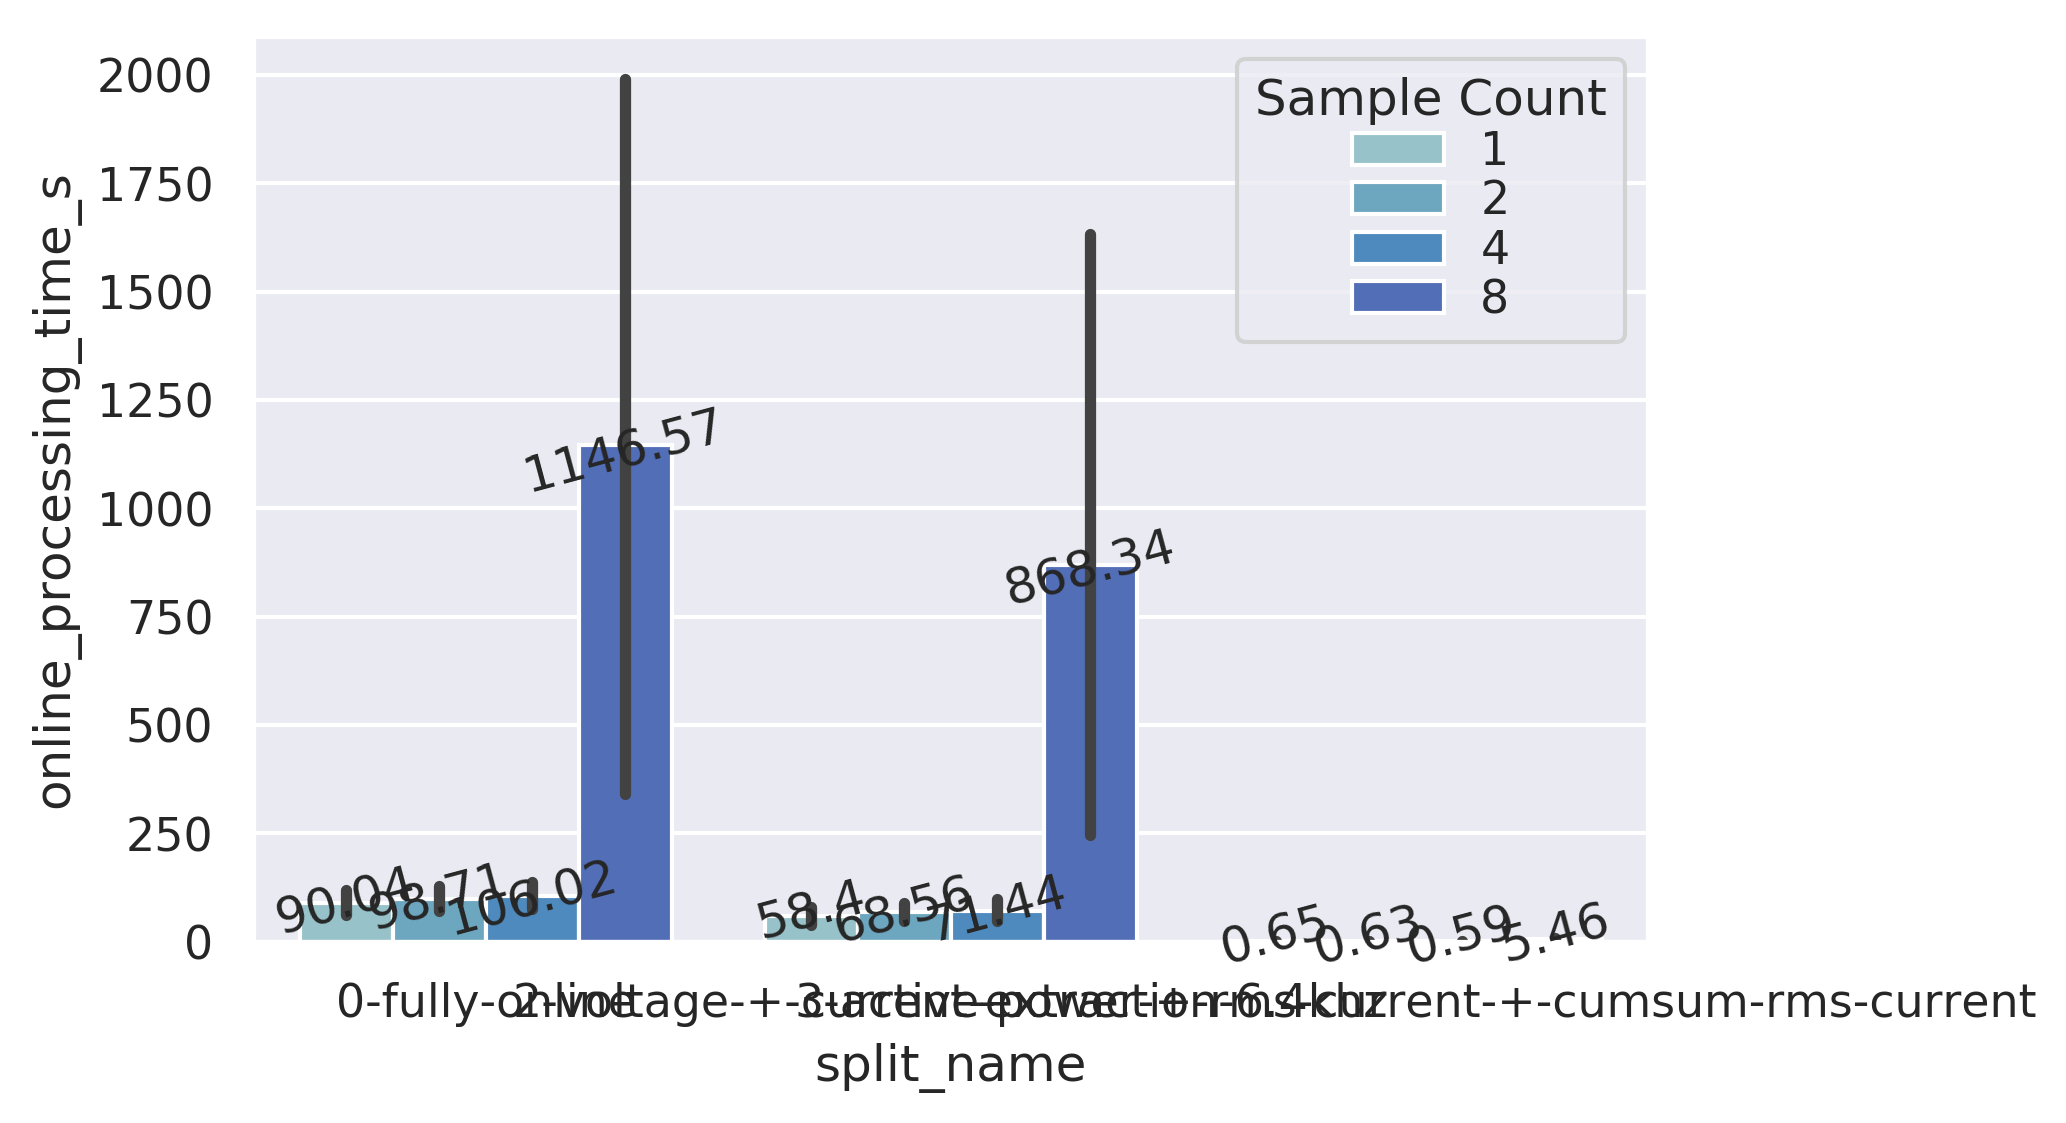

In [10]:
sns.set(palette=samples_palette)

cum_df_temp = cum_df_mod.query(f"runs_count==0")

plot = sns.barplot(
    x="split_name",
    y="online_processing_time_s",
    hue="thread_count",
    data=cum_df_temp
)
#plot.set_xticklabels(
#    strategies_renamed
# , rotation=10
#)
#plot.set(xlabel="Strategy", ylabel="Throughput in Samples per Seconds")
#plot.set(ylim=(0, 10000))
show_values_on_bars(plot, h_v="v", space=10, rotation=15, round_to=2)#, additional_space=[0,   0, 250
plot.legend(title="Sample Count", ncol=1, labelspacing=0.1)
#save_fig("sampling-throughput")

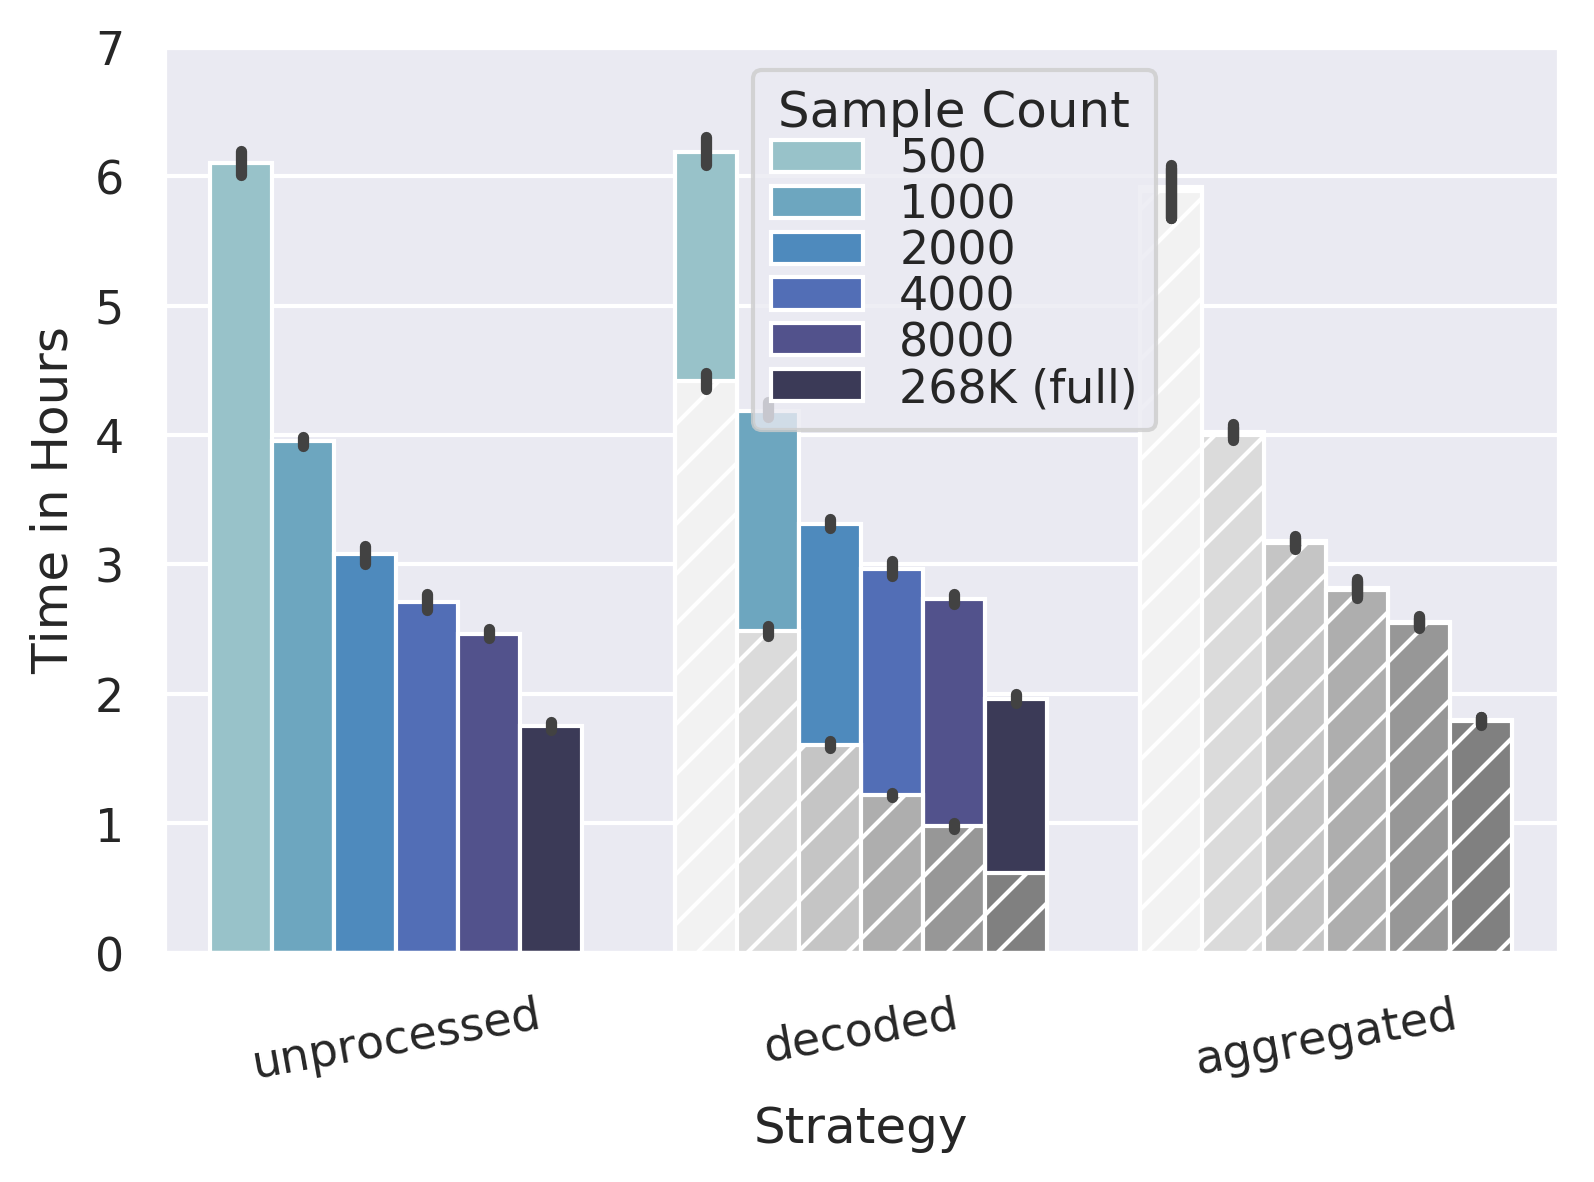

In [11]:
sns.set(palette=samples_palette)

cum_df_temp = cum_df_mod.query(f"runs_count==0 \
                             and thread_count==8")

plot = sns.barplot(
    x="split_name",
    y="full_dataset_processing_time_h",
    hue="sample_count",
    data=cum_df_temp
)
plot = sns.barplot(
    x="split_name",
    y="full_dataset_offline_processing_and_save_time_h",
    hue="sample_count",
    data=cum_df_temp,
    color="grey"
)

plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)

sample_counts = len(cum_df_temp.sample_count.unique())
strategies_count = len(cum_df_temp.split_name.unique())

for i,bar in enumerate(plot.patches):
    if i > (sample_counts * strategies_count):
        bar.set_hatch("//")

plot.set(xlabel="Strategy", ylabel="Time in Hours")
plot.set(ylim=(0, 7))

handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles[:sample_counts], title="Sample Count", loc="upper right", bbox_to_anchor=(0.728,1), ncol=1, labelspacing=0.02, columnspacing=0.3)
save_fig("extrapolated-dataset-processing-time")

# 5. Speedup
## 8000 samples + 1, 2, 4, 8 threads + epoch 0
### Calculate the speedup 

In [22]:
cum_8000_df = cum_df_mod.query("sample_count==8000")

parallel_capability = {
      "thread_count": []
    , "strategy": []
    , "speedup": []
    , "run": []
}

def add_capability(thread_count, strategy, speedup, run):
    parallel_capability["thread_count"] += [thread_count]
    parallel_capability["strategy"] += [strategy]
    parallel_capability["speedup"] += [speedup]
    parallel_capability["run"] += [run]

for strategy in strategies:
    for run_count in cum_8000_df.runs_count.unique():
        for thread_count in cum_8000_df.thread_count.unique():
            throughputs = cum_8000_df.query(f"thread_count=={thread_count} and split_name=='{strategy}' and runs_count=={run_count}")["throughput_sps"].to_numpy()
            for throughput in throughputs:
                avg_step_t1_throughput = cum_8000_df.query(f"thread_count=={1} and split_name=='{strategy}' and runs_count=={run_count}")["throughput_sps"].mean()
                # not using percentages here as I feel its more intuitive, benchmarking crimes is still followed from my understanding
                #if avg_step_t1_throughput < throughput:
                #    rel_increase_factor =  throughput / avg_step_t1_throughput - 1
                #    add_capability(thread_count, strategy, np.round(rel_increase_factor, 2))
                #else:
                #    rel_decrease_factor = 1 - throughput / avg_step_t1_throughput
                #    add_capability(thread_count, strategy, -np.round(rel_decrease_factor, 2))
                ## now using speedup instead of increase/decrease factor
                speedup = throughput / avg_step_t1_throughput
                add_capability(thread_count, strategy, speedup, run_count)
                print(f"strategy: {strategy}")
                print(f"t1 throughput mean: {avg_step_t1_throughput}")
                print(f"t{thread_count} throughput: {throughput}")
                print(f"speedup: {speedup}")


parallel_capability_df = pd.DataFrame(parallel_capability)
parallel_capability_df

strategy: 0-fully-online
t1 throughput mean: 35.911460876464844
t4 throughput: 31.839906692504883
speedup: 0.886622428894043
strategy: 0-fully-online
t1 throughput mean: 35.911460876464844
t4 throughput: 31.835430145263672
speedup: 0.8864977955818176
strategy: 0-fully-online
t1 throughput mean: 35.911460876464844
t4 throughput: 31.03743553161621
speedup: 0.8642765879631042
strategy: 0-fully-online
t1 throughput mean: 35.911460876464844
t4 throughput: 31.677387237548828
speedup: 0.8820968866348267
strategy: 0-fully-online
t1 throughput mean: 35.911460876464844
t4 throughput: 32.51618194580078
speedup: 0.905454158782959
strategy: 0-fully-online
t1 throughput mean: 35.911460876464844
t2 throughput: 33.8393440246582
speedup: 0.9422993063926697
strategy: 0-fully-online
t1 throughput mean: 35.911460876464844
t2 throughput: 34.786712646484375
speedup: 0.9686799645423889
strategy: 0-fully-online
t1 throughput mean: 35.911460876464844
t2 throughput: 33.194698333740234
speedup: 0.924348294734954

strategy: 2-voltage-+-current-extraction-6.4khz
t1 throughput mean: 53.042633056640625
t4 throughput: 45.73027801513672
speedup: 0.8621419072151184
strategy: 2-voltage-+-current-extraction-6.4khz
t1 throughput mean: 53.042633056640625
t4 throughput: 42.72884750366211
speedup: 0.8055566549301147
strategy: 2-voltage-+-current-extraction-6.4khz
t1 throughput mean: 53.042633056640625
t4 throughput: 43.774818420410156
speedup: 0.8252761363983154
strategy: 2-voltage-+-current-extraction-6.4khz
t1 throughput mean: 53.042633056640625
t2 throughput: 46.176876068115234
speedup: 0.8705615401268005
strategy: 2-voltage-+-current-extraction-6.4khz
t1 throughput mean: 53.042633056640625
t2 throughput: 46.131195068359375
speedup: 0.8697003126144409
strategy: 2-voltage-+-current-extraction-6.4khz
t1 throughput mean: 53.042633056640625
t2 throughput: 45.93938446044922
speedup: 0.8660841584205627
strategy: 2-voltage-+-current-extraction-6.4khz
t1 throughput mean: 53.042633056640625
t2 throughput: 48.2750

strategy: 3-active-power-+-rms-current-+-cumsum-rms-current
t1 throughput mean: 8071.50146484375
t2 throughput: 7259.56103515625
speedup: 0.8994064927101135
strategy: 3-active-power-+-rms-current-+-cumsum-rms-current
t1 throughput mean: 8071.50146484375
t2 throughput: 7372.0888671875
speedup: 0.9133478999137878
strategy: 3-active-power-+-rms-current-+-cumsum-rms-current
t1 throughput mean: 8071.50146484375
t2 throughput: 7840.30224609375
speedup: 0.9713560938835144
strategy: 3-active-power-+-rms-current-+-cumsum-rms-current
t1 throughput mean: 8071.50146484375
t2 throughput: 7521.6240234375
speedup: 0.9318742156028748
strategy: 3-active-power-+-rms-current-+-cumsum-rms-current
t1 throughput mean: 8071.50146484375
t2 throughput: 6891.1337890625
speedup: 0.8537610769271851
strategy: 3-active-power-+-rms-current-+-cumsum-rms-current
t1 throughput mean: 8071.50146484375
t1 throughput: 8180.60986328125
speedup: 1.0135177373886108
strategy: 3-active-power-+-rms-current-+-cumsum-rms-current
t

,thread_count,strategy,speedup,run
0,4,0-fully-online,0.886622,0
1,4,0-fully-online,0.886498,0
2,4,0-fully-online,0.864277,0
3,4,0-fully-online,0.882097,0
4,4,0-fully-online,0.905454,0
5,2,0-fully-online,0.942299,0
6,2,0-fully-online,0.968680,0
7,2,0-fully-online,0.924348,0
8,2,0-fully-online,0.940438,0
9,2,0-fully-online,0.945901,0


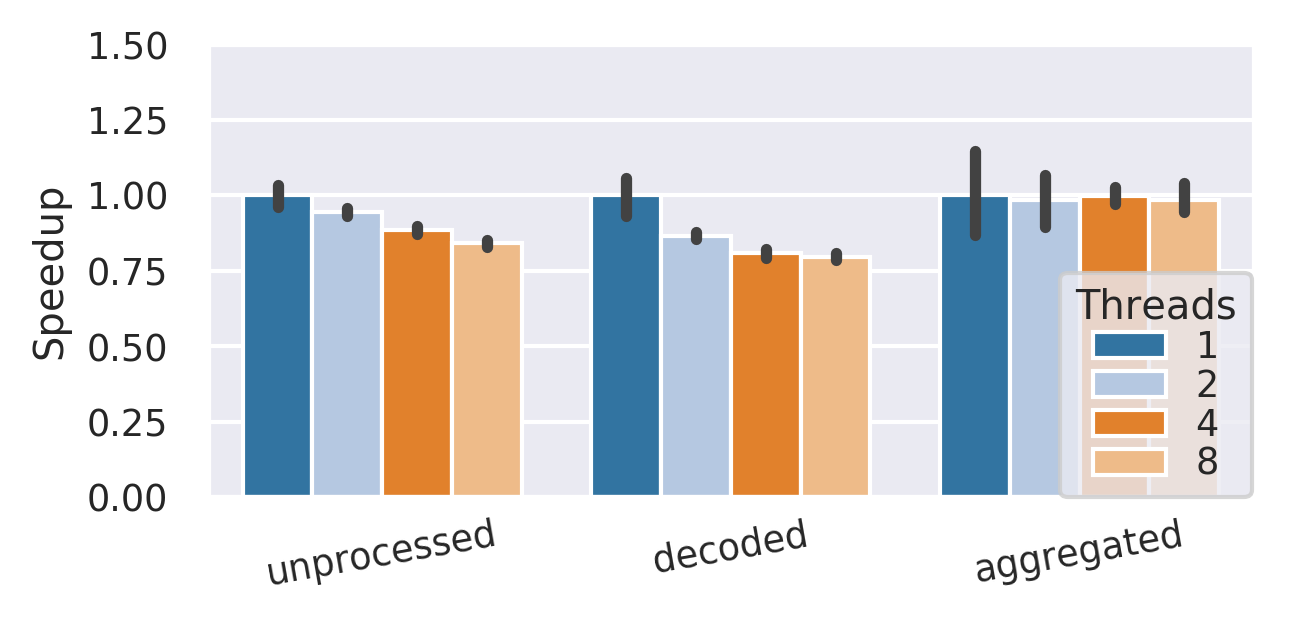

In [30]:
sns.set(palette=threads_palette, font_scale=0.8)

plt.figure(figsize=(4.5,2))
plot = sns.barplot(
    x="strategy",
    y="speedup",
    hue="thread_count",
    data=parallel_capability_df.query("run==0")
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.tick_params(axis='x', which='major', pad=-1.5)
#plot.set_title(f"Caching Speedup")
plot.set(xlabel="", ylabel="Speedup")
plot.set(ylim=(0, 1.5))
plot.legend(title="Threads", ncol=1,labelspacing=0.05, loc=(0.815,0.0))
save_fig("speedup-8000-samples-epoch-0")

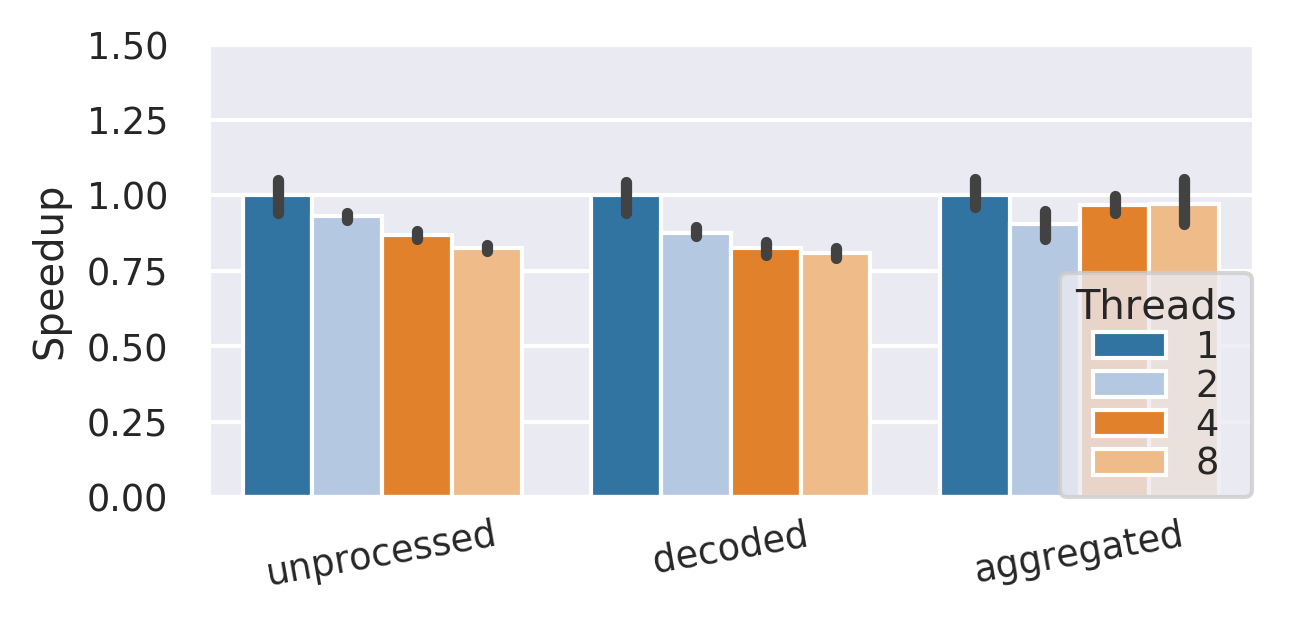

In [31]:
sns.set(palette=threads_palette, font_scale=0.8)

plt.figure(figsize=(4.5,2))
plot = sns.barplot(
    x="strategy",
    y="speedup",
    hue="thread_count",
    data=parallel_capability_df.query("run==1")
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.tick_params(axis='x', which='major', pad=-1.5)
#plot.set_title(f"Caching Speedup")
plot.set(xlabel="", ylabel="Speedup")
plot.set(ylim=(0, 1.5))
plot.legend(title="Threads", ncol=1,labelspacing=0.05, loc=(0.815,0.0))
save_fig("speedup-8000-samples-epoch-1")

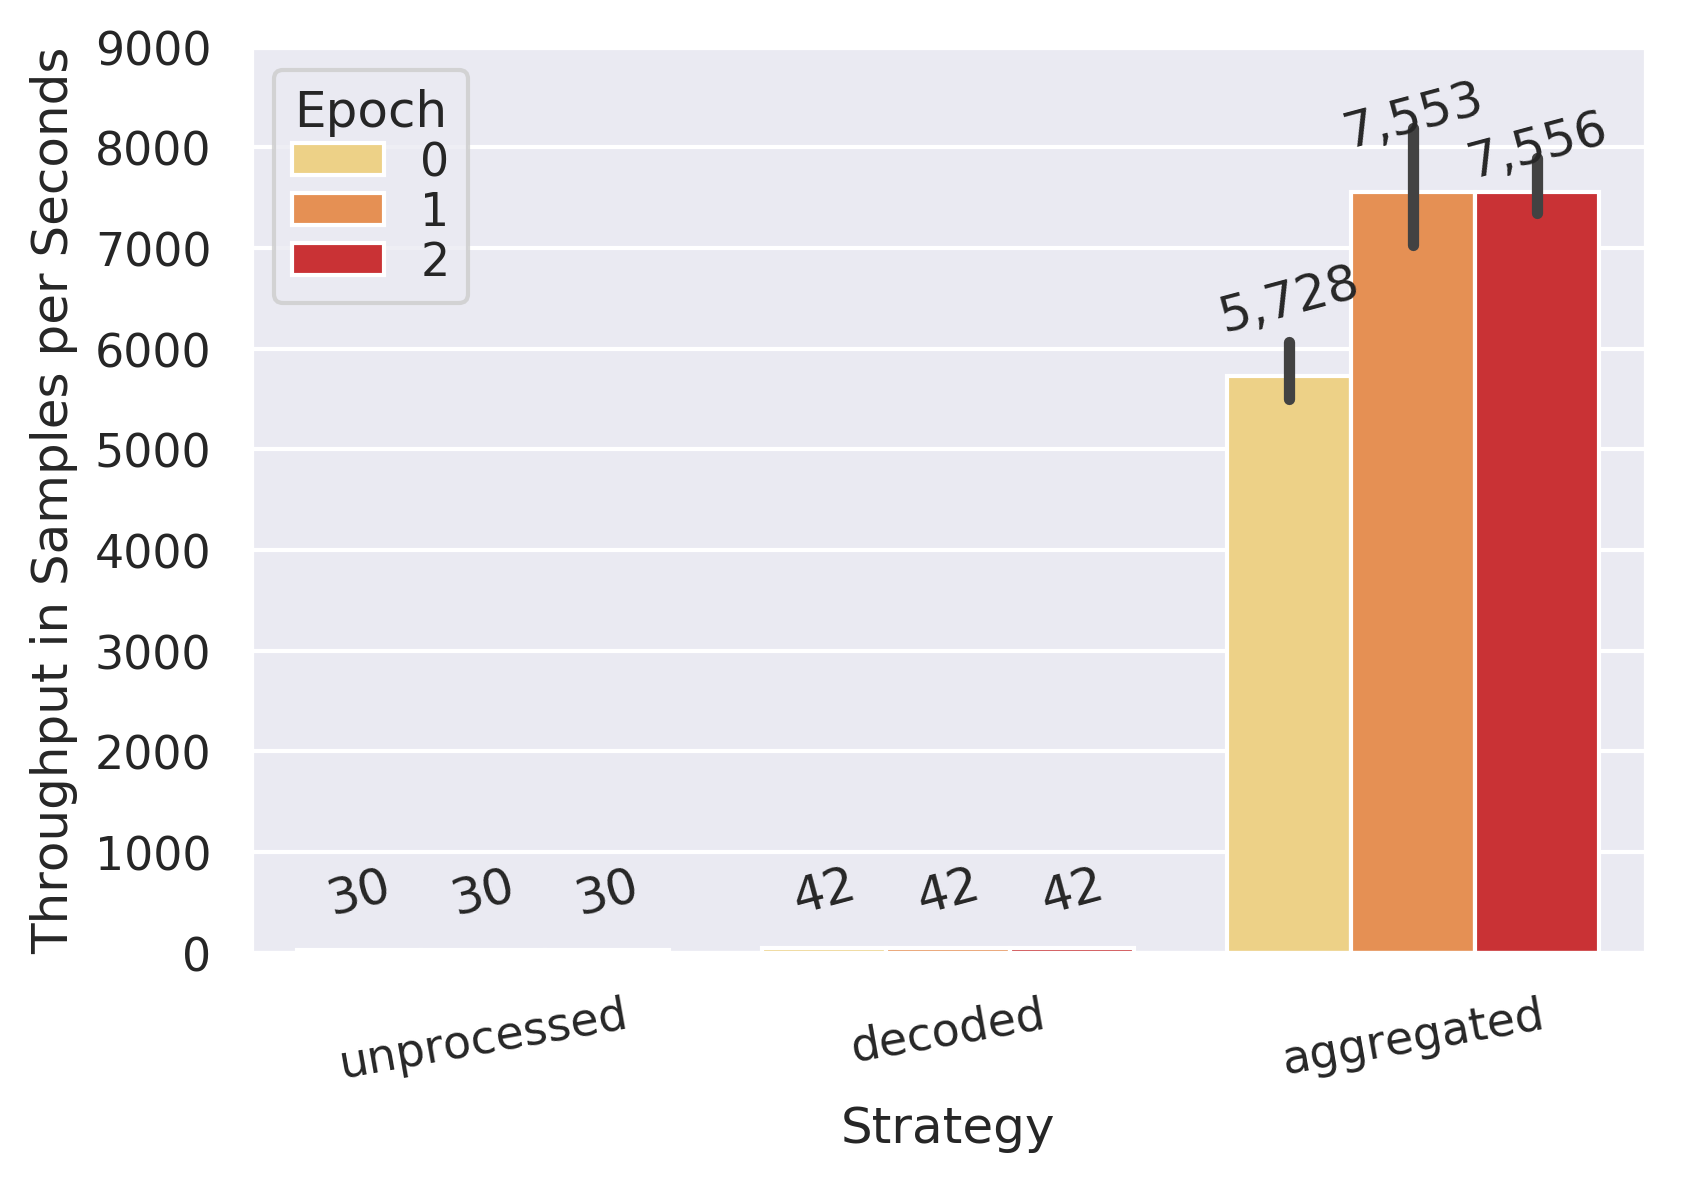

In [14]:
sns.set(palette=epoch_palette)
cum_df_temp = cum_df.query("sample_count==8000 and thread_count==8")

plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="runs_count",
    data=cum_df_temp
)

plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.set(xlabel="Strategy", ylabel="Throughput in Samples per Seconds")
plot.set(ylim=(0, 9000))
plot.legend(title="Epoch", ncol=1, labelspacing=0.1)
show_values_on_bars(plot, h_v="v", space=500, rotation=15, additional_space=[0,     0, 300
                                                                            ,0,     0, 300
                                                                            ,0,     0,   0,])
save_fig("throughput-8000-samples-epoch-0-1-2")

# X. Misc Plots and Calculations

## X.1 Calculation for the Introduction - unprocessed vs resized

In [7]:
unprocessed='0-fully-online'
resized='4-resize-image'
pixel_centered='5-center-pixel-values'
unprocessed_mean_throughput = cum_df.query(f"sample_count=={full_dataset_samplecount} and thread_count==8 and split_name=='{unprocessed}'")["throughput_sps"].mean()
resized_mean_throughput = cum_df.query(f"sample_count=={full_dataset_samplecount} and thread_count==8 and split_name=='{resized}'")["throughput_sps"].mean()
full_mean_throughput = cum_df.query(f"sample_count=={full_dataset_samplecount} and thread_count==8 and split_name=='{pixel_centered}'")["throughput_sps"].mean()
print(f"Unprocessed    strategy throughput (8 threads):  {np.round(unprocessed_mean_throughput,0)} sps")
print(f"Resized        strategy throughput (8 threads): {np.round(resized_mean_throughput,0)} sps")
print(f"Pixel-centered strategy throughput (8 threads):  {np.round(full_mean_throughput,0)} sps")

Unprocessed    strategy throughput (8 threads):  43.0 sps
Resized        strategy throughput (8 threads): nan sps
Pixel-centered strategy throughput (8 threads):  nan sps


## X.2 Warning - Creating the plots based on `dstat` logs can take several hours

In [8]:
cum_dstat_df_copy = cum_dstat_df.copy(deep=True)
cum_dstat_df_copy["sample_count"] = cum_dstat_df_copy.sample_count.astype('category')
cum_dstat_df_copy["split_name"] = cum_dstat_df_copy.split_name.astype('category')
cum_dstat_df_copy["run"] = cum_dstat_df_copy.run.astype('category')
cum_dstat_df_copy["thread_count"] = cum_dstat_df_copy.thread_count.astype('category')
strategy_list = list(cum_dstat_df_copy.split_name.unique())
strategy_list

['0-fully-online',
 '2-voltage-+-current-extraction-6.4khz',
 '3-active-power-+-rms-current-+-cumsum-rms-current']

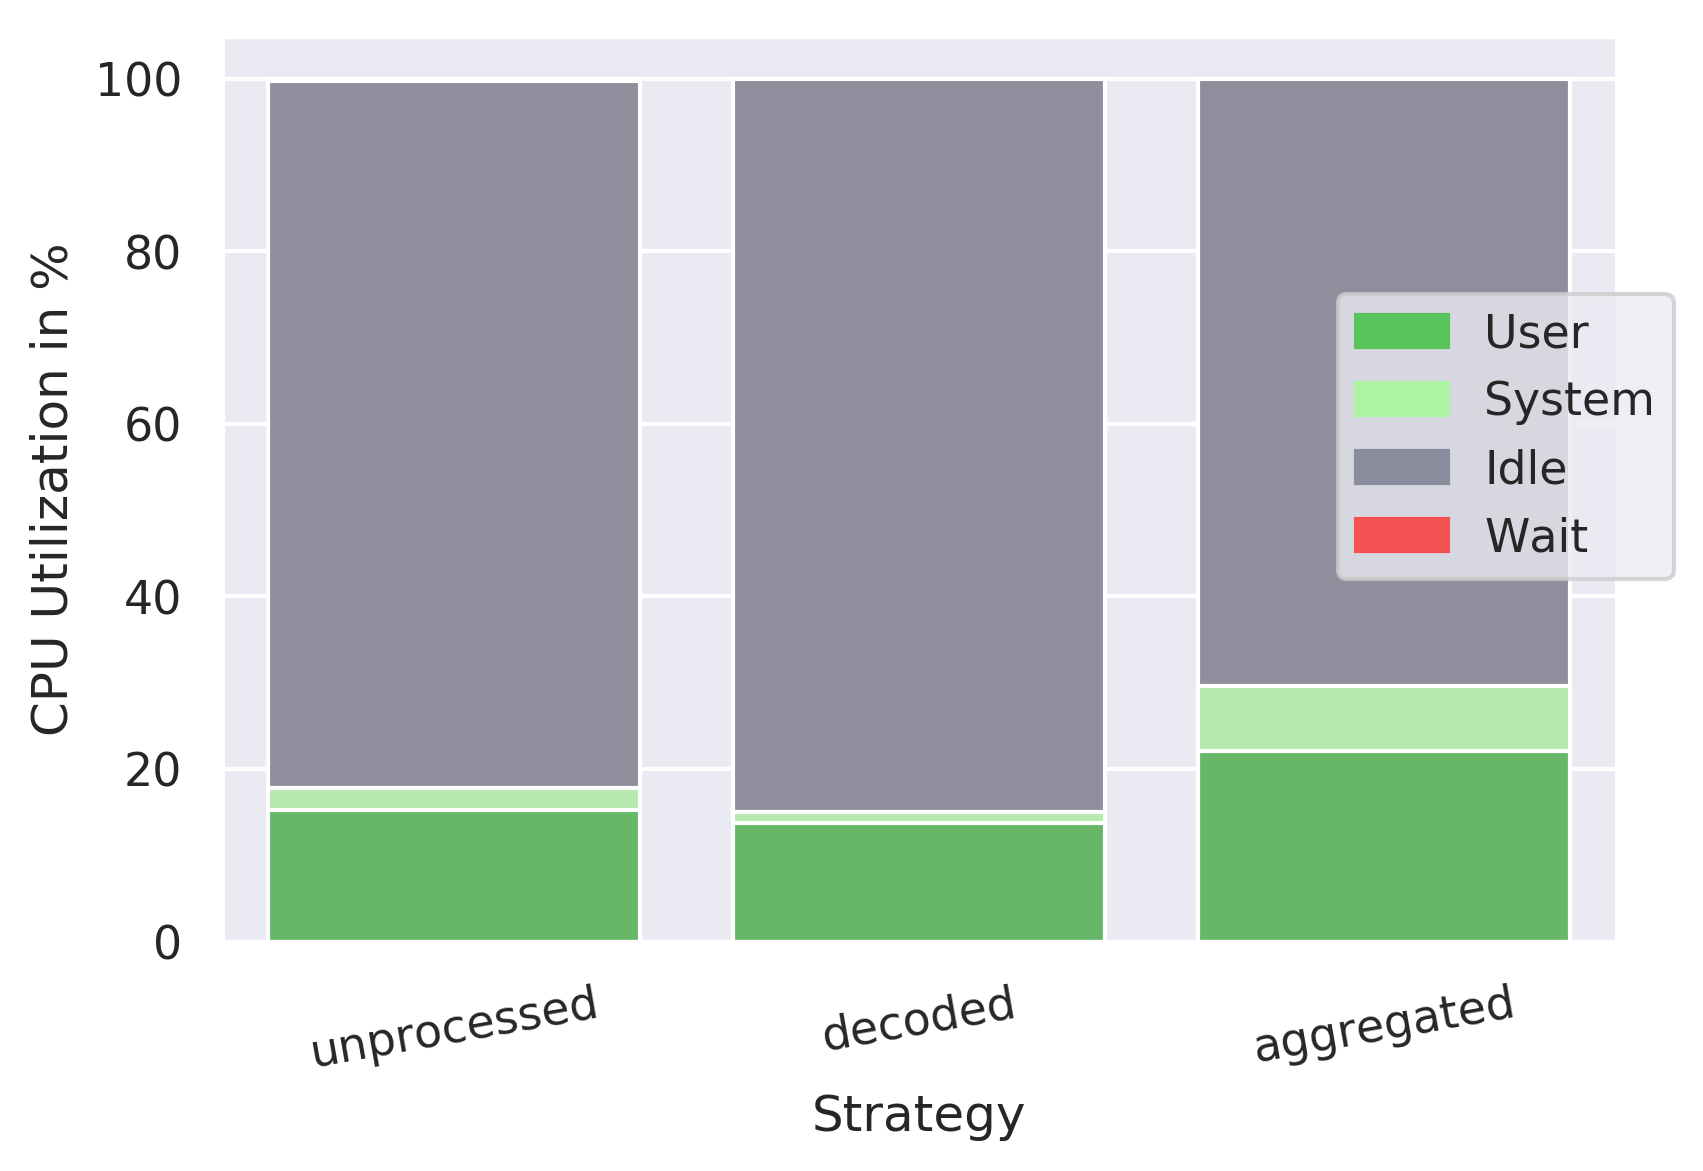

In [7]:
def extract_cpu_online_processing_time(split_name):
    '''
    '''
    run = 0
    threads = 8
    sample_count = full_dataset_samplecount
    
    
    max_offline_processing_time_s = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["offline_processing_and_save_time_s"].max()
    
    filtered_dstat_df = cum_dstat_df.query(
        f"split_name=='{split_name}' and \
          run=={run} and \
          thread_count=={threads} and \
          rel_time_s>={max_offline_processing_time_s}")
    
    
    
    return filtered_dstat_df[['rel_time_s','cpu_usr_in_percent',
       'cpu_sys_in_percent', 'cpu_idle_in_percent', 'cpu_wait_in_percent','split_name']]

split_names = cum_df.split_name.unique()

frames = [extract_cpu_online_processing_time(split_name=split_name) for split_name in split_names]

online_cpu_df = pd.concat(frames)

def create_cumulative_and_aggregated_cpu_values(df):
    
    cpu_dict = {
        'split_name': []
      , 'cpu_usr_cum': []
      , 'cpu_sys_cum': []
      , 'cpu_idle_cum': []
      , 'cpu_wait_cum': []
    }
    
    def add_to_dict(split_name, usr, sys, idle, wait):
        cpu_dict['split_name'] += [split_name]
        cpu_dict['cpu_usr_cum'] += [usr]
        cpu_dict['cpu_sys_cum'] += [sys]
        cpu_dict['cpu_idle_cum'] += [idle]
        cpu_dict['cpu_wait_cum'] += [wait]
    
    for split_name in split_names:
        describe_df = df.query(f"split_name=='{split_name}'").describe()
        mean_df = describe_df.iloc[1] # get the mean
        mean_df['split_name'] = split_name
        mean_df['cpu_usr_sys_in_percent'] = mean_df['cpu_usr_in_percent'] \
                                          + mean_df['cpu_sys_in_percent']
        mean_df['cpu_usr_sys_idle_in_percent'] = mean_df['cpu_usr_sys_in_percent'] \
                                               + mean_df['cpu_idle_in_percent']
        mean_df['cpu_usr_sys_idle_wait_in_percent'] = mean_df['cpu_usr_sys_idle_in_percent'] \
                                                    + mean_df['cpu_wait_in_percent']

        mean_df['cpu_usr_cum'] = mean_df['cpu_usr_in_percent']
        mean_df['cpu_sys_cum'] = mean_df['cpu_usr_sys_in_percent']
        mean_df['cpu_idle_cum'] = mean_df['cpu_usr_sys_idle_in_percent']
        mean_df['cpu_wait_cum'] = mean_df['cpu_usr_sys_idle_wait_in_percent']
        add_to_dict(split_name=split_name, usr=mean_df['cpu_usr_cum']
                   ,sys=mean_df['cpu_sys_cum']
                   ,idle=mean_df['cpu_idle_cum']
                   ,wait=mean_df['cpu_wait_cum'])
    
    return pd.DataFrame(cpu_dict)
    
cumulative_cpu_df = create_cumulative_and_aggregated_cpu_values(df=online_cpu_df)

green1 = "#5AC45C"
green2 = "#acf4a3"
grey = "#8c8c9f"
red = "#f45252"

bar4 = sns.barplot(x="split_name",  y="cpu_wait_cum", data=cumulative_cpu_df, color=red)
bar3 = sns.barplot(x="split_name",  y="cpu_idle_cum", data=cumulative_cpu_df, color=grey)
bar2 = sns.barplot(x="split_name",  y="cpu_sys_cum", data=cumulative_cpu_df, color=green2)
bar1 = sns.barplot(x="split_name",  y="cpu_usr_cum", data=cumulative_cpu_df, color=green1)
plot = bar1

plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.set(xlabel="Strategy", ylabel="CPU Utilization in %")

# add legend
legend_bar1 = mpatches.Patch(color=green1, label='User')
legend_bar2 = mpatches.Patch(color=green2, label='System')
legend_bar3 = mpatches.Patch(color=grey, label='Idle')
legend_bar4 = mpatches.Patch(color=red, label='Wait')
plt.legend(handles=[legend_bar1,legend_bar2,legend_bar3,legend_bar4], loc=(0.8,0.4))

In [14]:
run = 0
threads = 8
sample_count = full_dataset_samplecount

def extract_online_processing_frames(split_name):
    '''
    '''    
    
    max_offline_processing_time_s = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["offline_processing_and_save_time_s"].max()
    print(max_offline_processing_time_s)
    filtered_dstat_df = cum_dstat_df.query(
        f"split_name=='{split_name}' and \
          run=={run} and \
          thread_count=={threads} and \
          rel_time_s>={max_offline_processing_time_s}")
    
    return filtered_dstat_df

split_names = cum_df.split_name.unique()
frames = [extract_online_processing_frames(split_name=split_name) for split_name in split_names]
online_df = pd.concat(frames)

for split_name in cum_df.split_name.unique():
    
    avg_online_processing_time = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["online_processing_time_s"].describe().iloc[1]
    
    
    print("---------------------------------------")
    print(f"-- {split_name} Network Read in MB/s --")
    print(f"-- {split_name} Online Processing time: {int(avg_online_processing_time)}")
    
    temp_df = online_df.query(f"split_name=='{split_name}'")
    print(temp_df.describe()["net_read_mbs"])

0.0
2226.5952
6635.045
---------------------------------------
-- 0-fully-online Network Read in MB/s --
-- 0-fully-online Online Processing time: 6291
count    34407.000000
mean         6.225218
std         17.179432
min          0.000000
25%          0.000180
50%          0.000303
75%          0.000705
max        213.681290
Name: net_read_mbs, dtype: float64
---------------------------------------
-- 2-voltage-+-current-extraction-6.4khz Network Read in MB/s --
-- 2-voltage-+-current-extraction-6.4khz Online Processing time: 4847
count    24241.000000
mean        54.278332
std         21.918163
min          0.000120
25%         47.747051
50%         67.332329
75%         67.334503
max        187.299026
Name: net_read_mbs, dtype: float64
---------------------------------------
-- 3-active-power-+-rms-current-+-cumsum-rms-current Network Read in MB/s --
-- 3-active-power-+-rms-current-+-cumsum-rms-current Online Processing time: 29
count     32.000000
mean      96.499016
std       42.7

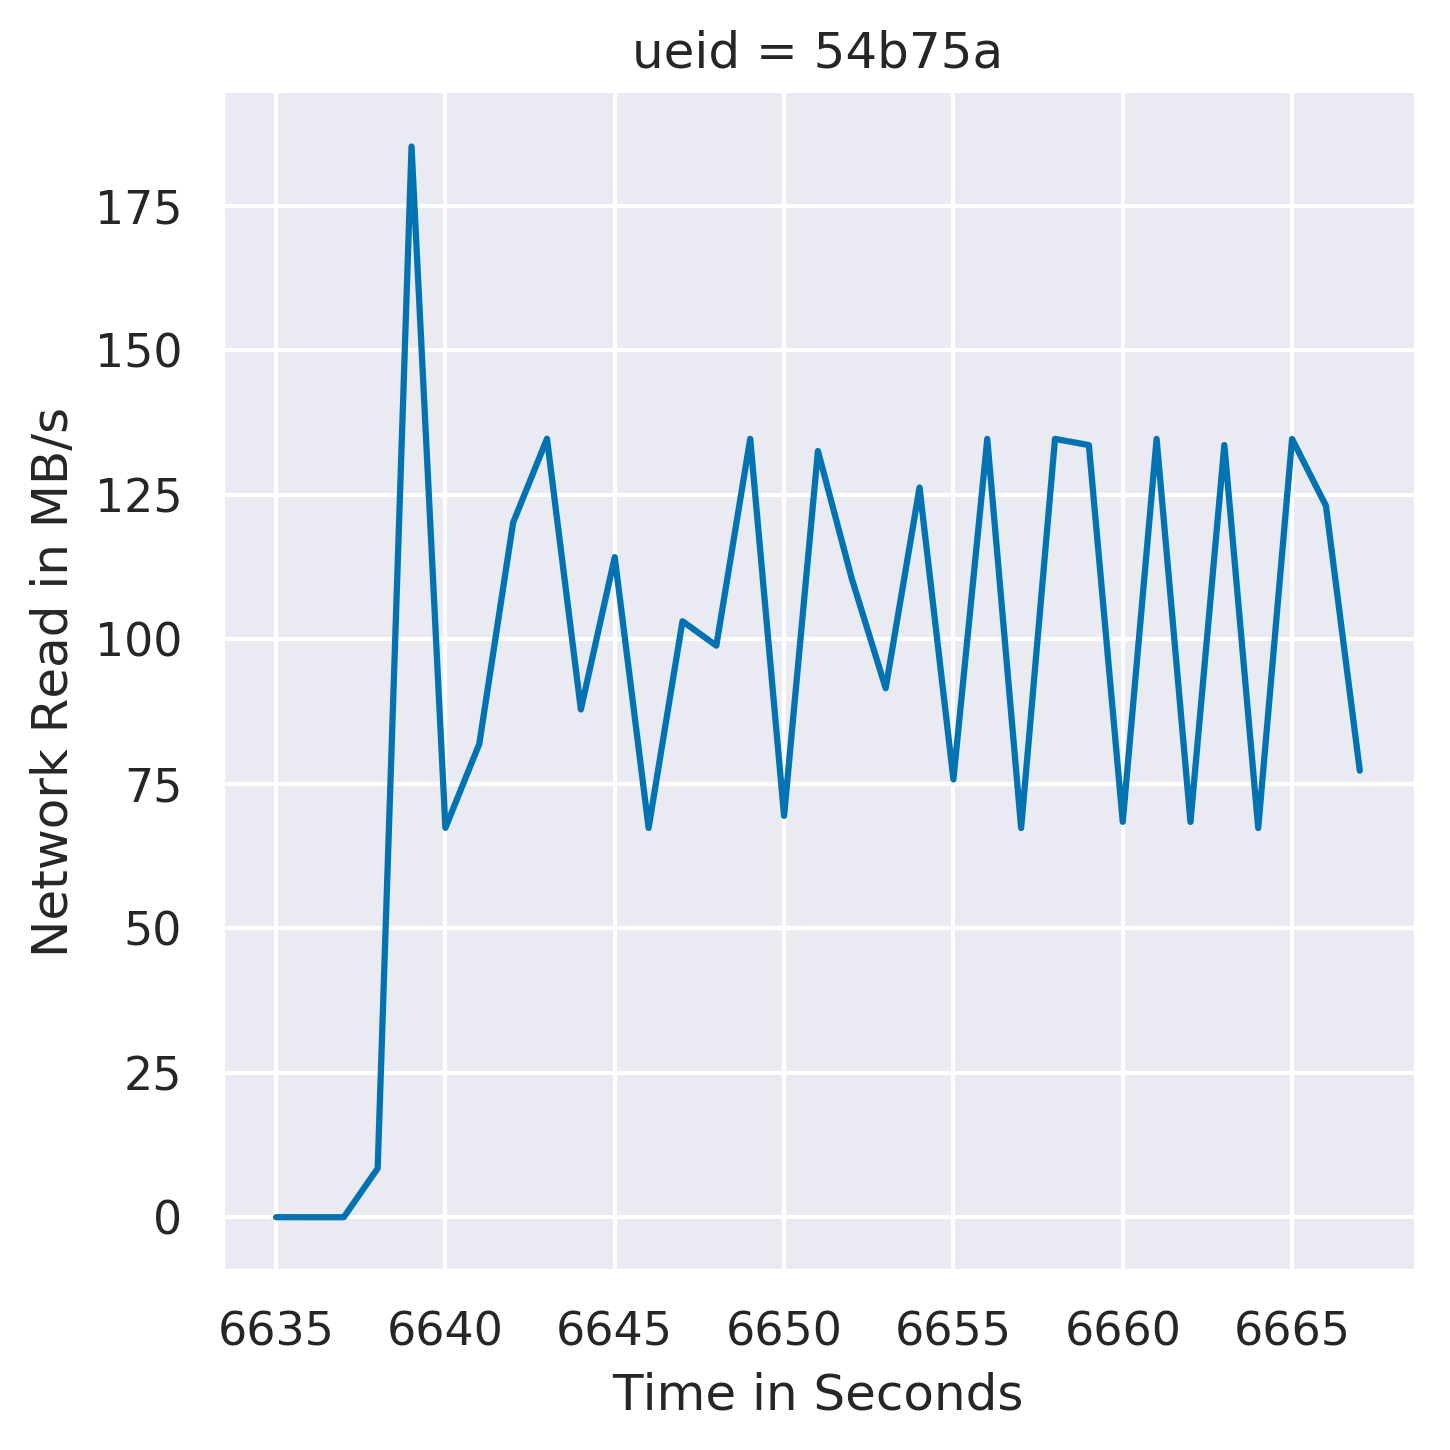

In [15]:
sns.set(palette=default_palette)

cum_dstat_df_temp = cum_dstat_df_copy.query(f"sample_count=={full_dataset_samplecount} and \
                                              thread_count==8 and \
                                              run==0 and rel_time_s>=6635")
plot = sns.relplot(
    x="rel_time_s",
    y="net_read_mbs",
    col="ueid",
    kind="line",
    data=cum_dstat_df_temp.query("split_name=='3-active-power-+-rms-current-+-cumsum-rms-current'"),
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Read in MB/s")
#plot.set(ylim=(0, 1200))
#plot.axhline(1100, color="black")
#plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
#save_fig("network-read-speed-t8-full", file_type="png")

,ueid,offline_processing_and_save_time_s
225,f90289,147.162064
1185,6eb627,155.941071
945,f962c0,148.620239
465,0fad6c,155.628494
705,7d6d85,146.598434


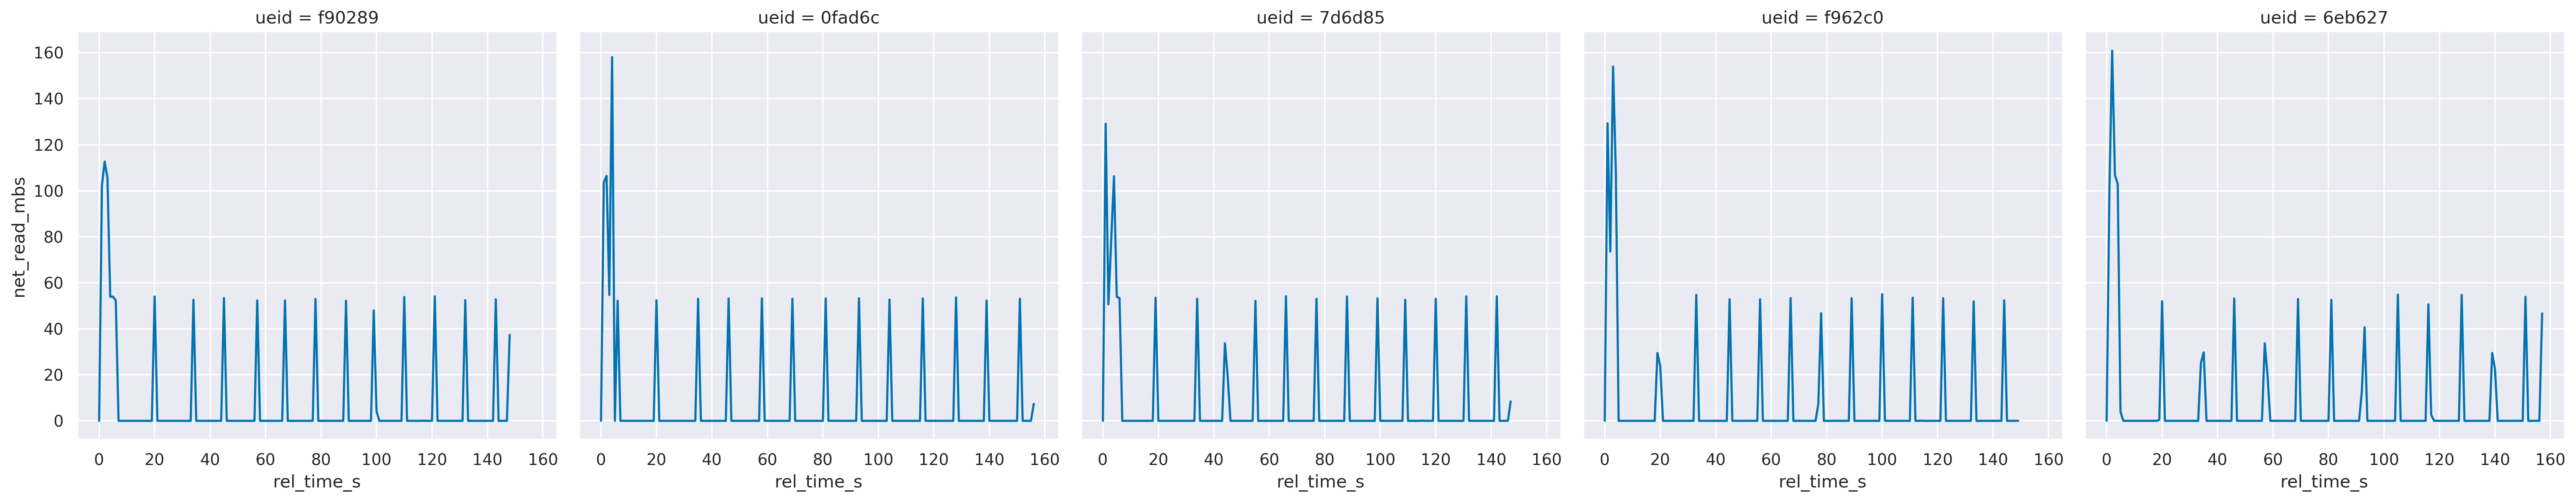

In [26]:
sns.set(palette=default_palette)

cum_dstat_df_temp = cum_dstat_df_copy.query(f"sample_count=={4000} and \
                                              thread_count==8 and \
                                              split_name=='3-active-power-+-rms-current-+-cumsum-rms-current' and \
                                              run==0")
plot = sns.relplot(
    x="rel_time_s",
    y="net_read_mbs",
    col="ueid",
    kind="line",
    data=cum_dstat_df_temp,#.query("rel_time_s>=268"),
    ci=95
)

temp_df = cum_df.query(f"sample_count=={4000} and \
                                              thread_count==8 and \
                                              split_name=='3-active-power-+-rms-current-+-cumsum-rms-current' and \
                                              runs_count==0")
temp_df[['ueid', 'offline_processing_and_save_time_s']]

#plot.set(xlabel="Time in Seconds", ylabel="Cached Memory in MB")
#plot.set(ylim=(0, 1200))
#plot.axhline(1100, color="black")
#plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
#save_fig("network-read-speed-t8-full", file_type="png")

In [27]:
cum_dstat_df_copy.columns

Index(['rel_time_s', 'disk_read_mbs', 'disk_write_mbs', 'net_read_mbs',
       'net_write_mbs', 'run', 'sample_count', 'shard_count', 'thread_count',
       'ueid', 'split_name', 'creation_timestamp', 'cpu_usr_in_percent',
       'cpu_sys_in_percent', 'cpu_idle_in_percent', 'cpu_wait_in_percent',
       'system_interrupts_per_s', 'system_context_switches_per_s',
       'memory_free_mb', 'memory_buffered_mb', 'memory_used_mb',
       'memory_cached_mb', 'vm_major_pagefaults', 'vm_minor_pagefaults',
       'vm_allocated_mb', 'vm_free_mb', 'filesystem_files',
       'filesystem_inodes', 'filelocks_posix', 'filelocks_lock',
       'filelocks_read', 'filelocks_write', 'compression_type',
       'storage_type'],
      dtype='object')

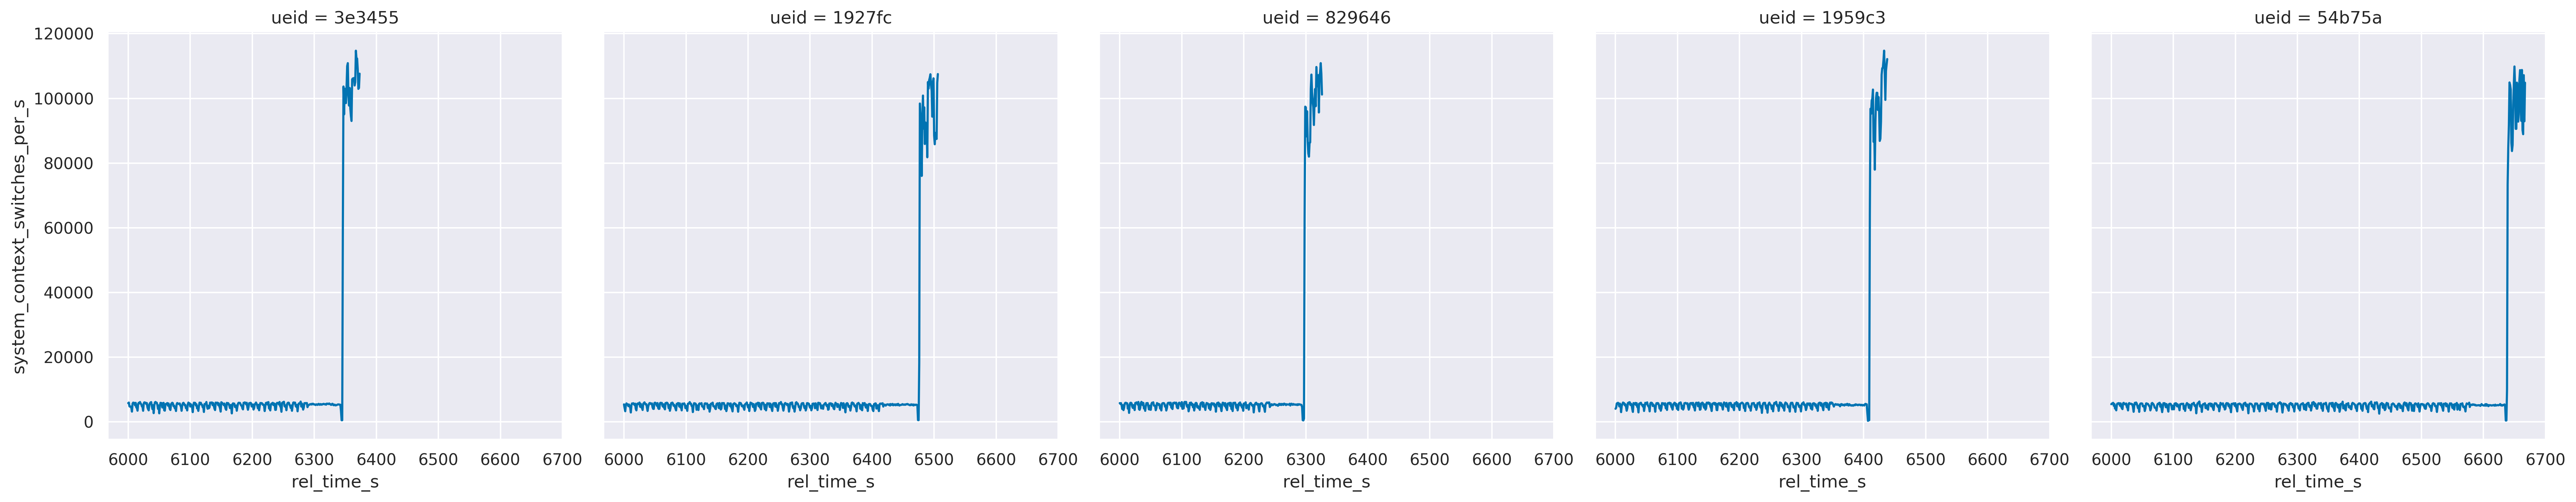

In [33]:
sns.set(palette=default_palette)

cum_dstat_df_temp = cum_dstat_df_copy.query(f"sample_count=={full_dataset_samplecount} and \
                                              thread_count==8 and \
                                              split_name=='3-active-power-+-rms-current-+-cumsum-rms-current' and \
                                              run==0")
plot = sns.relplot(
    x="rel_time_s",
    y="system_context_switches_per_s",
    col="ueid",
    kind="line",
    data=cum_dstat_df_temp.query("rel_time_s>=6000"),
    ci=95
)

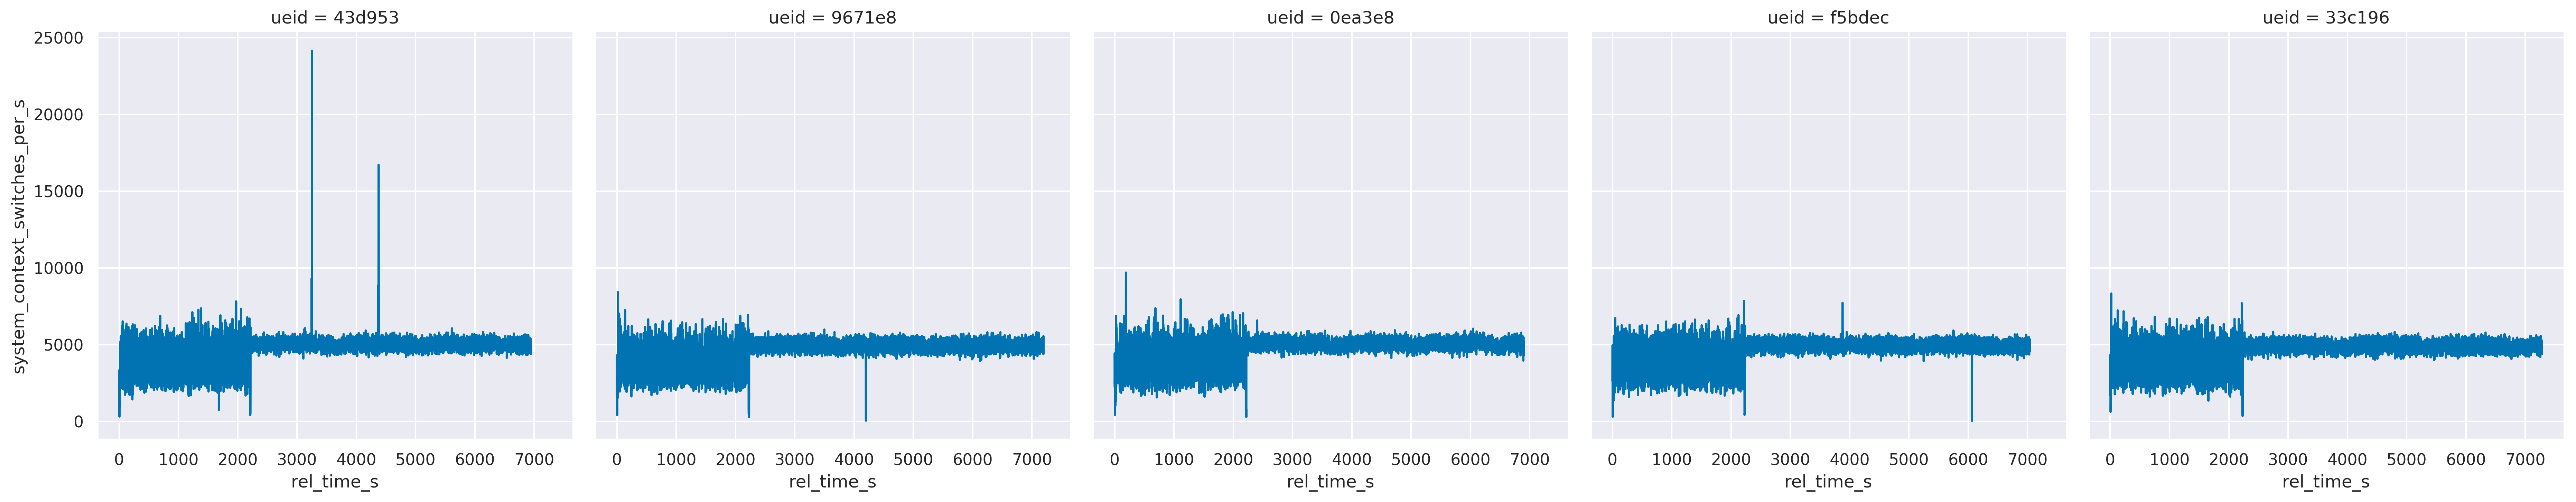

In [35]:
sns.set(palette=default_palette)

cum_dstat_df_temp = cum_dstat_df_copy.query(f"sample_count=={full_dataset_samplecount} and \
                                              thread_count==8 and \
                                              split_name=='2-voltage-+-current-extraction-6.4khz' and \
                                              run==0")
plot = sns.relplot(
    x="rel_time_s",
    y="system_context_switches_per_s",
    col="ueid",
    kind="line",
    data=cum_dstat_df_temp,#.query("rel_time_s>=6000"),
    ci=95
)

/home/asa/.miniconda/envs/presto/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


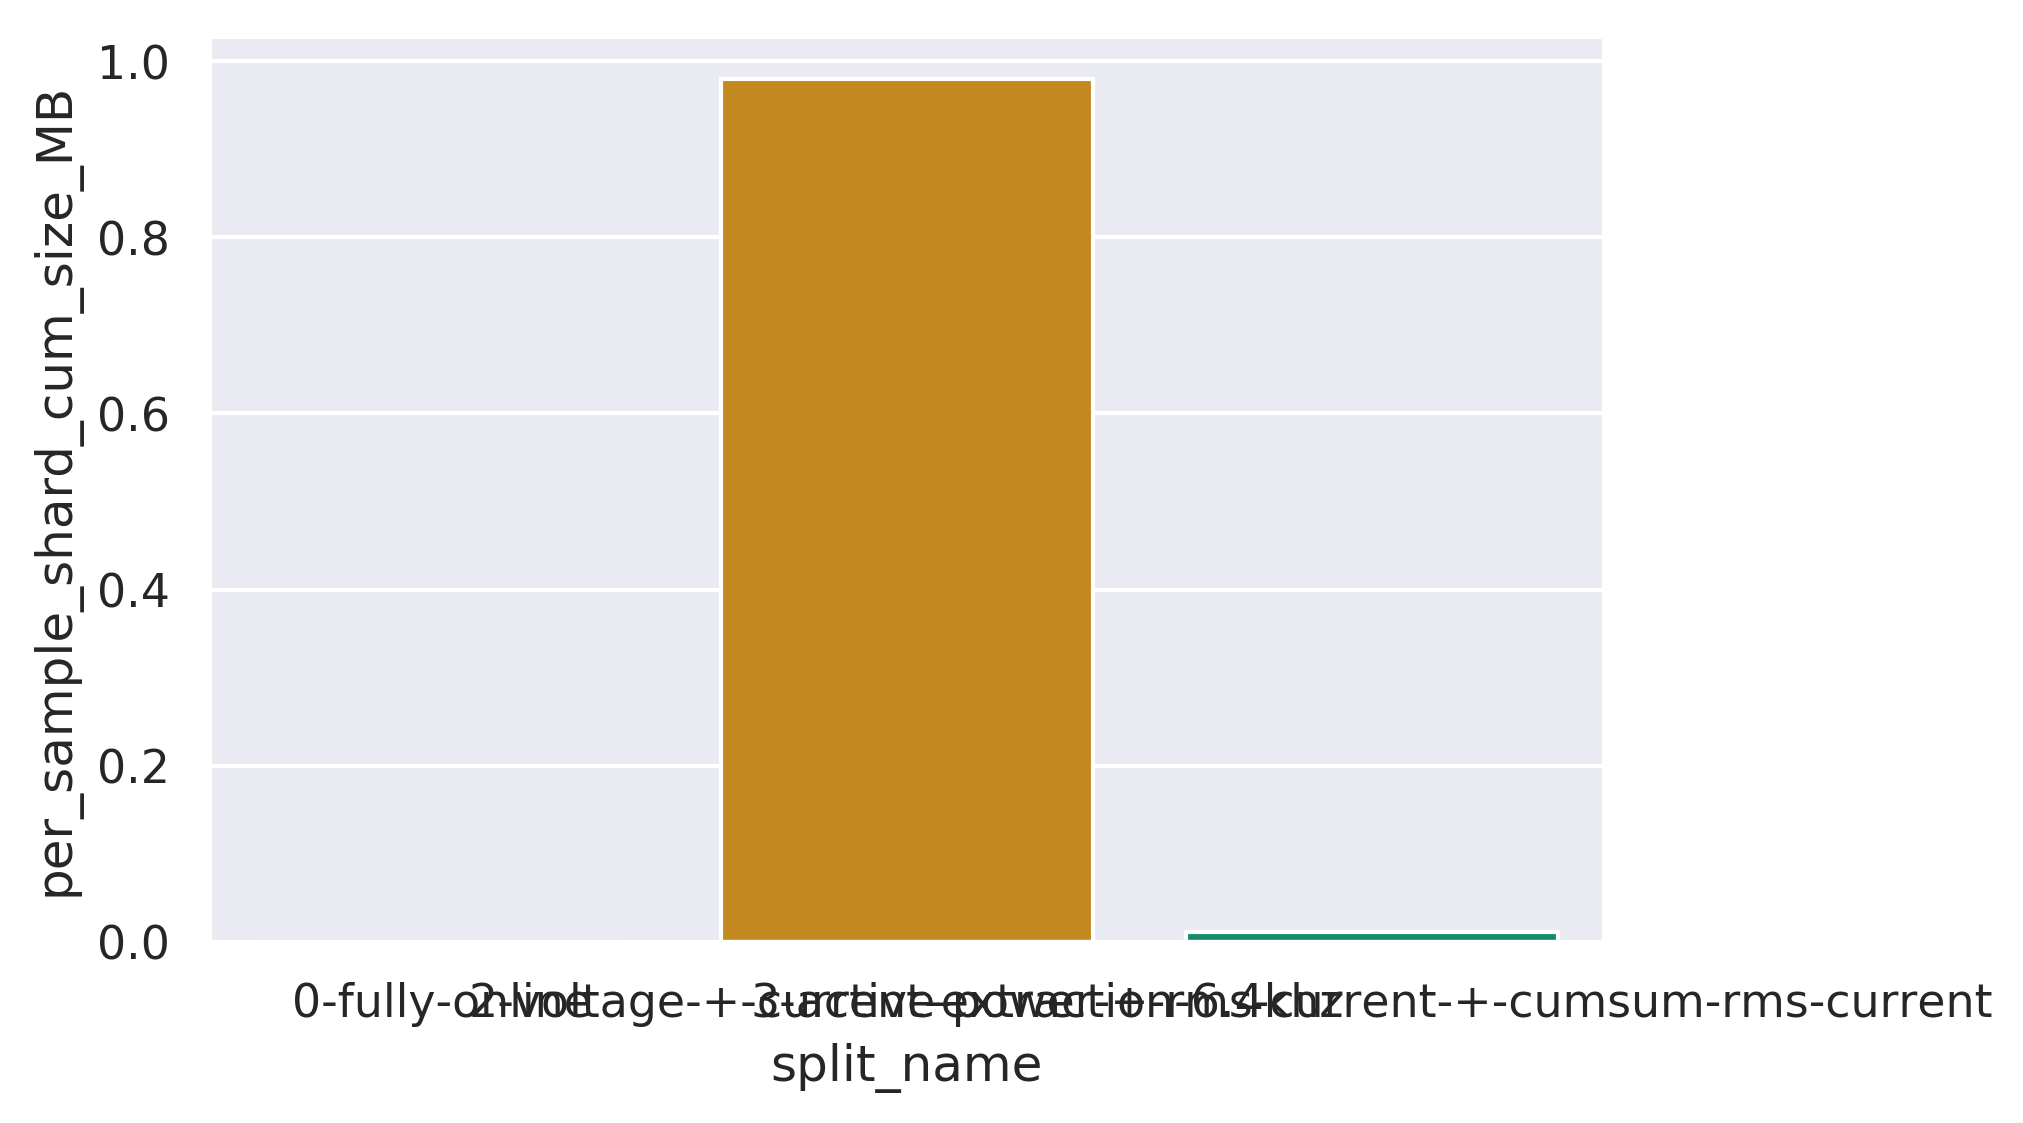

In [36]:
sns.set(palette=default_palette)
import sys

temp_df = cum_df.query(f"sample_count=={full_dataset_samplecount} and \
                                              thread_count==8 and \
                                              runs_count==0")

temp_df["per_sample_shard_cum_size_MB"] = temp_df["shard_cum_size_MB"] / full_dataset_samplecount


plot = sns.barplot(
    x="split_name",
    y="per_sample_shard_cum_size_MB",
    data=temp_df,
    ci=95
)